In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error

## Partie 1 : Exploration des Donnees

### Question 1.1

Chargez le dataset et affichez ses informations de base :

- Nombre d'observations et de variables
- Types de donnees
- Presence de valeurs manquantes
- Statistiques descriptives

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
           'acceleration', 'model_year', 'origin', 'car_name']
df = pd.read_csv(url, sep='\s+', names=columns, na_values='?')

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_20964\3989941799.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(url, sep='\s+', names=columns, na_values='?')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


- Une variable catégorielle *car_name*, les autres sont numériques.
- La colonne *horsepower* contient 398 - 392 = 6 valeurs nulles.

In [4]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


array([[<Axes: title={'center': 'mpg'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'displacement'}>],
       [<Axes: title={'center': 'horsepower'}>,
        <Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>],
       [<Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'origin'}>, <Axes: >]], dtype=object)

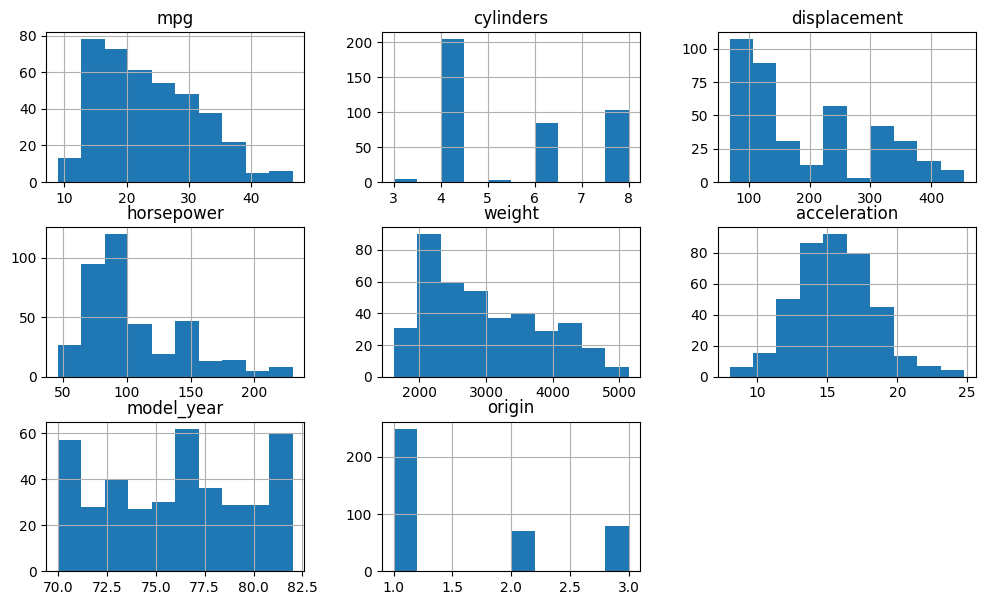

In [5]:
df.hist(figsize=(12,7))

Les véhicules avec 3 ou 5 cylindres sont en sous effectif.

Text(0, 0.5, 'Moyenne des concommations (mpg)')

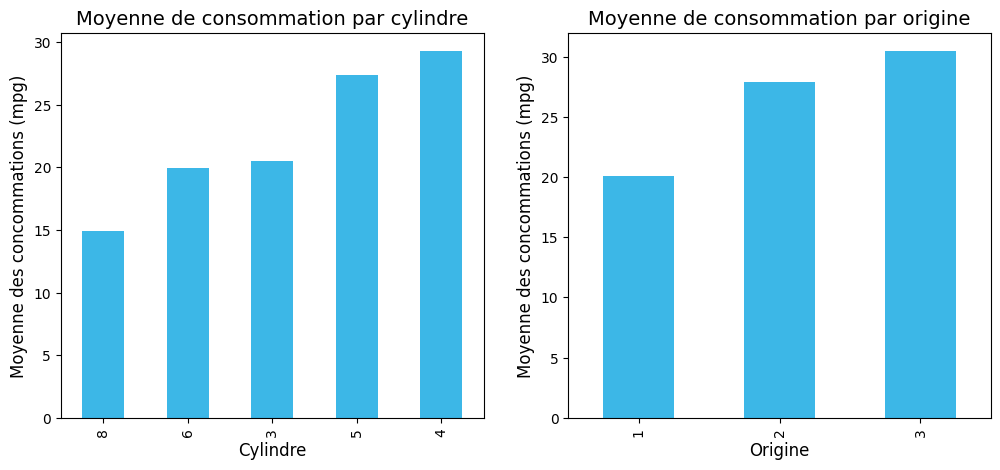

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ax1 = axes[0]
education_class = df.groupby("cylinders")["mpg"].mean().sort_values()
education_class.plot(kind="bar", color="#3CB7E7", ax=ax1)
ax1.set_title("Moyenne de consommation par cylindre", fontsize=14)
ax1.set_xlabel("Cylindre", fontsize=12)
ax1.set_ylabel("Moyenne des concommations (mpg)", fontsize=12)

ax2 = axes[1]
education_class = df.groupby("origin")["mpg"].mean().sort_values()
education_class.plot(kind="bar", color="#3CB7E7", ax=ax2)
ax2.set_title("Moyenne de consommation par origine", fontsize=14)
ax2.set_xlabel("Origine", fontsize=12)
ax2.set_ylabel("Moyenne des concommations (mpg)", fontsize=12)

On pourra tenir compte de la répartition des véhicules par cylindre et par origine dans la construction des datasets de training et de test.

<Axes: title={'center': 'Matrice de corrélation'}>

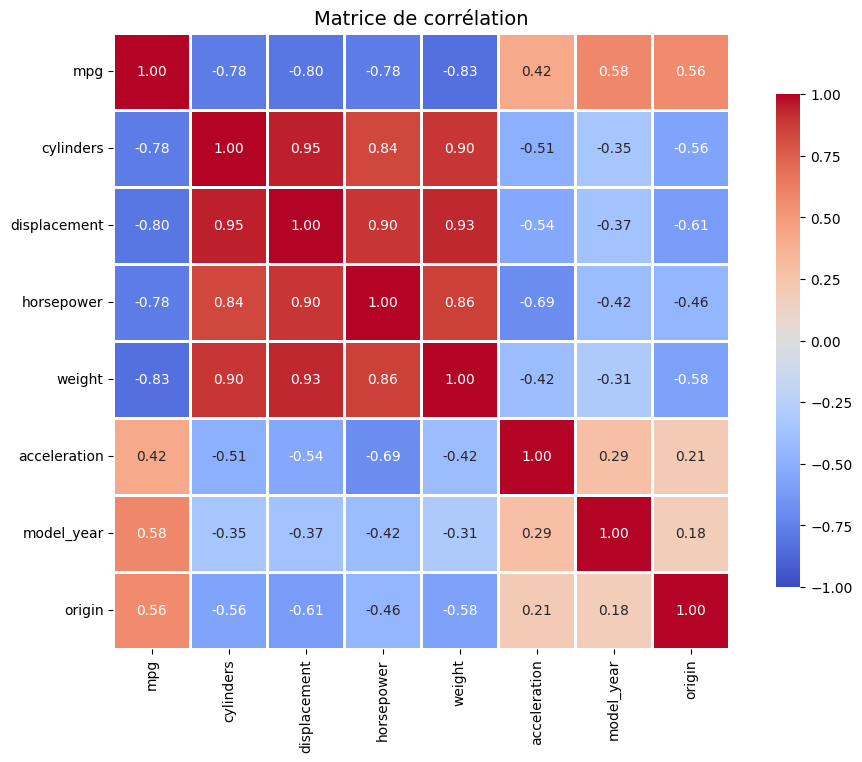

In [7]:
df_corr = df.select_dtypes(include=["int", "float"]).copy()
mat_corr = df_corr.corr(method="pearson")

plt.figure(figsize=(12,8))
plt.title("Matrice de corrélation", fontsize=14)

sns.heatmap(
    mat_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    fmt=".2f",
)

In [8]:
def trouver_correleations_fortes(matrice_corr: pd.DataFrame, seuil: float = 0.5):
    paires = []
    cols = matrice_corr.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            r = matrice_corr.iloc[i, j]
            if abs(r) >= seuil:
                paires.append(
                    {
                        "Variable_1": cols[i],
                        "Variable_2": cols[j],
                        "Corrélation": round(r, 3),
                    }
                )
    resultats = pd.DataFrame(paires)
    resultats_trie = resultats.sort_values(
        "Corrélation",
        ascending=False,
        key=abs,
    )
    return resultats_trie


correlations_fortes = trouver_correleations_fortes(mat_corr, seuil=0.5)

correlations_fortes.head(20)

,Variable_1,Variable_2,Corrélation
6,cylinders,displacement,0.951
12,displacement,weight,0.933
11,displacement,horsepower,0.897
8,cylinders,weight,0.896
15,horsepower,weight,0.865
7,cylinders,horsepower,0.843
3,mpg,weight,-0.832
1,mpg,displacement,-0.804
2,mpg,horsepower,-0.778
0,mpg,cylinders,-0.775


Présence de corrélations fortes entre les variables numériques. Une ACP pourrait permet de réduire le nombre de dimensions.

### Question 1.2

Gerez les valeurs manquantes :

- Identifiez les colonnes avec des valeurs manquantes
- Choisissez une strategie appropriee (suppression ou imputation)
- Justifiez votre choix

In [9]:
null_counts = df.isna().sum()
print("Valeur nulles :")
print(null_counts)

Valeur nulles :
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


Suppression des données manquantes.

In [10]:
df_clean = df.dropna()

### Question 1.3

Analysez la distribution de la variable cible (mpg) :

- Tracez un histogramme
- Calculez les statistiques de centralite et dispersion
- La distribution est-elle normale ? Faut-il la transformer ?

array([[<Axes: title={'center': 'mpg'}>]], dtype=object)

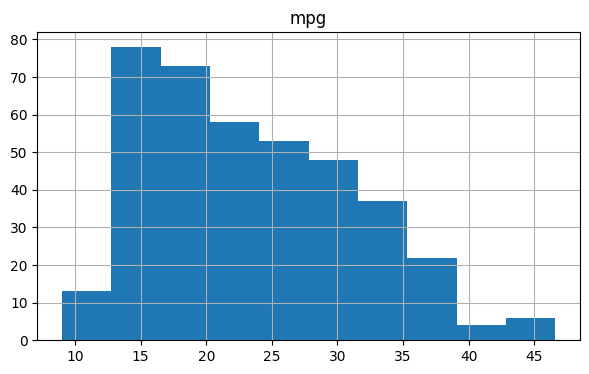

In [11]:
df_clean.hist(column="mpg", figsize=(7,4))

In [12]:
print("Caractéristiques de position")
print("  Moyenne : ", df_clean["mpg"].mean())
print("  Médiane : ", df_clean["mpg"].median())
print("Caractéristiques de dispersions")
print("  Etendue : ", df_clean["mpg"].max() - df["mpg"].min())
print("  Ecart-type : ", df_clean["mpg"].std())

Caractéristiques de position
  Moyenne :  23.445918367346938
  Médiane :  22.75
Caractéristiques de dispersions
  Etendue :  37.6
  Ecart-type :  7.8050074865717995


In [13]:
from scipy.stats import shapiro

statistic, p_value = shapiro(df["mpg"])

print("Statistic W test Shapiro : ", statistic)
print("p-value test Shapiro : ", p_value)

Statistic W test Shapiro :  0.9679659577379658
p-value test Shapiro :  1.1833854157896544e-07


Le test de shapiro est significatif : p-value << 0.01 et montre que la distribution de mpg est normale statistic W = 0.96.

### Question 1.4

Explorez les correlations :

- Creez une matrice de correlation
- Identifiez les variables les plus correlees avec mpg
- Y a-t-il des problemes de multicolinearite entre les features ?

Nombreuses corrélations fortes entre les variables numériques. Il y a donc multicolinéarité entre les features.

## Partie 2 : Preprocessing

### Question 2.1

Preparez les features pour la modelisation :

- Separez la variable cible des features
- Traitez la variable categorielle `origin` (encodage)

In [47]:
X = df_clean[["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin"]]
y = df_clean["mpg"]

In [48]:
numeric_features = X.select_dtypes(include=["int", "float"]).columns.to_list()
categorical_features = X.select_dtypes(include=["object"]).columns.to_list()

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### Question 2.2

Divisez les donnees en ensembles d'entrainement et de test :

- Utilisez 80% pour l'entrainement
- Fixez random_state=42 pour la reproductibilite

In [55]:
stratify_col = df_clean["cylinders"].astype(str) + "_" + df_clean["origin"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_col)

### Question 2.3

Standardisez les features numeriques :

- Appliquez StandardScaler sur les donnees d'entrainement
- Transformez les donnees de test avec le meme scaler

In [56]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Partie 3 : Entrainement du Modele

### Question 3.1

Entrainez un modele de regression lineaire simple

Evaluez le modele avec :

- R-squared (coefficient de determination)
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)

In [57]:
ml_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("classifier", LinearRegression()),
    ]
)

ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['cylinders', 'displacement',
                                                   'horsepower', 'weight',
                                                   'acceleration', 'model_year',
                                                   'origin']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier', LinearRegression())])

In [58]:
y_pred = ml_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"{mae = }")
print(f"{mse = }")
print(f"{rmse = }")
print(f"{r2 = }")

mae = 2.0541681512836343
mse = 7.825858461013688
rmse = 2.7974735854005286
r2 = 0.8624303333679979
